# ✈️ Flight Delay Analysis — End-to-End Notebook

This notebook runs a complete **delay analysis** on your uploaded dataset.

**Included steps:**
1. Load & inspect data  
2. Data cleaning & standardization  
3. Missing value report and imputation (Mean/Median/Mode where appropriate)  
4. Feature engineering (e.g., delay flags, time features, rates)  
5. Outlier detection (Z-score)  
6. Correlation analysis & heatmap  
7. Top-10 insights (airlines, routes, airports)  
8. Time-series delay trends and heatmaps (Month × Hour)  

> Charts are made with **matplotlib only** (no seaborn).

In [30]:
# =============================
# Config
# =============================
DATA_PATH = "flight_delay.csv"  # Uploaded file path
SAVE_CLEAN_CSV = True
CLEAN_CSV_PATH = "flight_delay_cleaned.csv"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime


In [31]:
# =============================
# Helper functions
# =============================
def to_numeric(series):
    return pd.to_numeric(series, errors='coerce')

def minutes_since_midnight(t):
    # Convert strings like 'HH:MM', 'H:MM', or compact '930' -> minutes since midnight.
    import math
    if pd.isna(t):
        return np.nan
    s = str(t).strip()
    # compact HHMM or HMM
    if s.isdigit() and 3 <= len(s) <= 4:
        try:
            if len(s) == 3:
                hh = int(s[0])
                mm = int(s[1:3])
            else:
                hh = int(s[:2])
                mm = int(s[2:4])
            return hh * 60 + mm
        except Exception:
            return np.nan
    # 'HH:MM'
    try:
        parts = s.split(':')
        hh = int(parts[0])
        mm = int(parts[1])
        return hh * 60 + mm
    except Exception:
        return np.nan

def parse_date(s):
    # Parse date in tolerant manner; returns NaT if cannot parse.
    if pd.isna(s):
        return pd.NaT
    s = str(s).strip()
    fmts = ("%Y-%m-%d", "%d-%m-%Y", "%d/%m/%Y", "%m/%d/%Y", "%d %b %Y", "%d %B %Y")
    for fmt in fmts:
        try:
            return pd.to_datetime(s, format=fmt)
        except Exception:
            pass
    # fallback auto
    return pd.to_datetime(s, errors='coerce', dayfirst=True)

def zscore(series):
    x = series.astype(float)
    mu = np.nanmean(x)
    sd = np.nanstd(x, ddof=0)
    if sd == 0 or np.isnan(sd):
        return pd.Series([np.nan]*len(series), index=series.index)
    return (x - mu) / sd


In [50]:
# =============================
# Load & Inspect
# =============================
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nPreview:")
display(df)

print("\nMissing values per column:")
display(df.isna().sum())

orig_df = df.copy()


Shape: (10718, 29)

Columns: ['Used Date', 'From', 'To', 'Airline', 'Scheduled Departure', 'SDEP', 'Departure', 'DEP', 'Scheduled Arrival', 'SARR', 'Arrival', 'ARR', 'Departure Delay', 'Arrival Delay', 'Status', 'Distance', 'Passenger Load Factor', 'Airline Rating', 'Airport Rating', 'Market Share', 'OTP Index', 'weather__hourly__windspeedKmph', 'weather__hourly__weatherDesc__value', 'weather__hourly__precipMM', 'weather__hourly__humidity', 'weather__hourly__visibility', 'weather__hourly__pressure', 'weather__hourly__cloudcover', 'Category']

Preview:


,Used Date,From,To,Airline,Scheduled Departure,SDEP,Departure,DEP,Scheduled Arrival,SARR,...,Market Share,OTP Index,weather__hourly__windspeedKmph,weather__hourly__weatherDesc__value,weather__hourly__precipMM,weather__hourly__humidity,weather__hourly__visibility,weather__hourly__pressure,weather__hourly__cloudcover,Category
0,31-01-2020,DEL,HYD,Air Asia,06:05,605,06:04,604,08:15,815,...,5.3,85.6,11,Partly cloudy,0,90,9,1012,57,0
1,31-01-2020,DEL,HYD,Indigo,04:50,450,04:36,436,07:00,700,...,47.5,81.1,11,Partly cloudy,0,90,9,1012,57,0
2,30-01-2020,DEL,HYD,Air Asia,06:05,605,05:54,554,08:15,815,...,5.3,85.6,11,Partly cloudy,0,90,9,1012,57,0
3,30-01-2020,DEL,HYD,Air Asia,17:40,1740,17:40,1740,19:55,1955,...,5.3,85.6,11,Partly cloudy,0,90,9,1012,57,0
4,30-01-2020,DEL,HYD,Air Asia,19:50,1950,19:54,1954,22:10,2210,...,5.3,85.6,11,Partly cloudy,0,90,9,1012,57,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10713,24-01-2019,CCU,DEL,SpiceJet,18:30,1830,18:30,1830,20:55,2055,...,13.3,69.2,6,Clear,0,29,10,1016,1,0
10714,23-01-2019,CCU,DEL,SpiceJet,18:30,1830,18:30,1830,20:55,2055,...,13.3,69.2,3,Clear,0,27,10,1015,0,0
10715,22-01-2019,CCU,DEL,SpiceJet,18:30,1830,18:38,1838,20:55,2055,...,13.3,69.2,5,Clear,0,28,10,1015,0,1
10716,09-01-2019,DEL,HYD,Spicejet,22:05,2205,00:40,40,00:25,25,...,13.3,69.2,8,Patchy rain possible,1,55,9,997,85,4



Missing values per column:


Used Date                              0
From                                   0
To                                     0
Airline                                0
Scheduled Departure                    0
SDEP                                   0
Departure                              0
DEP                                    0
Scheduled Arrival                      0
SARR                                   0
Arrival                                0
ARR                                    0
Departure Delay                        0
Arrival Delay                          0
Status                                 0
Distance                               0
Passenger Load Factor                  0
Airline Rating                         0
Airport Rating                         0
Market Share                           0
OTP Index                              0
weather__hourly__windspeedKmph         0
weather__hourly__weatherDesc__value    0
weather__hourly__precipMM              0
weather__hourly_

In [33]:
# =============================
# Data Cleaning & Standardization
# =============================
df.columns = [c.strip() for c in df.columns]

date_col = "Used Date" if "Used Date" in df.columns else None
time_cols = [c for c in ["Scheduled Departure","SDEP","Departure","DEP","Scheduled Arrival","SARR","Arrival","ARR"] if c in df.columns]

# Parse date column
if date_col:
    df[date_col] = df[date_col].apply(parse_date)
    df = df[~df[date_col].isna()].copy()

# Convert time-like columns to minutes since midnight
for c in time_cols:
    df[c + "_mins"] = df[c].apply(minutes_since_midnight)

numeric_candidates = [
    "Departure Delay","Arrival Delay","Distance","Passenger Load Factor",
    "Airline Rating","Airport Rating","Market Share","OTP Index",
    "weather__hourly__windspeedKmph","weather__hourly__precipMM",
    "weather__hourly__humidity","weather__hourly__visibility",
    "weather__hourly__pressure","weather__hourly__cloudcover"
]
for c in numeric_candidates:
    if c in df.columns:
        df[c] = to_numeric(df[c])

for c in ["From","To","Airline","Status","weather__hourly__weatherDesc__value","Category"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

print("After cleaning, shape:", df.shape)
display(df.head())


After cleaning, shape: (10718, 37)


,Used Date,From,To,Airline,Scheduled Departure,SDEP,Departure,DEP,Scheduled Arrival,SARR,...,weather__hourly__cloudcover,Category,Scheduled Departure_mins,SDEP_mins,Departure_mins,DEP_mins,Scheduled Arrival_mins,SARR_mins,Arrival_mins,ARR_mins
0,2020-01-31,DEL,HYD,Air Asia,06:05,605,06:04,604,08:15,815,...,57,0,365,365.0,364.0,364.0,495,495.0,496.0,496.0
1,2020-01-31,DEL,HYD,Indigo,04:50,450,04:36,436,07:00,700,...,57,0,290,290.0,276.0,276.0,420,420.0,415.0,415.0
2,2020-01-30,DEL,HYD,Air Asia,06:05,605,05:54,554,08:15,815,...,57,0,365,365.0,354.0,354.0,495,495.0,482.0,482.0
3,2020-01-30,DEL,HYD,Air Asia,17:40,1740,17:40,1740,19:55,1955,...,57,0,1060,1060.0,1060.0,1060.0,1195,1195.0,1182.0,1182.0
4,2020-01-30,DEL,HYD,Air Asia,19:50,1950,19:54,1954,22:10,2210,...,57,1,1190,1190.0,1194.0,1194.0,1330,1330.0,1334.0,1334.0


In [34]:
# =============================
# Missing Value Imputation
# =============================
print("Missing values BEFORE imputation:")
display(df.isna().sum())

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
for c in num_cols:
    if df[c].isna().any():
        med = df[c].median()
        if pd.isna(med):
            df[c] = df[c].fillna(df[c].mean())
        else:
            df[c] = df[c].fillna(med)

cat_cols = [c for c in df.columns if df[c].dtype == "object"]
for c in cat_cols:
    if df[c].isna().any():
        mode_val = df[c].mode(dropna=True)
        if len(mode_val):
            df[c] = df[c].fillna(mode_val.iloc[0])

print("\nMissing values AFTER imputation:")
display(df.isna().sum())

if SAVE_CLEAN_CSV:
    df.to_csv(CLEAN_CSV_PATH, index=False)
    print(f"Saved cleaned data to: {CLEAN_CSV_PATH}")


Missing values BEFORE imputation:


Used Date                                0
From                                     0
To                                       0
Airline                                  0
Scheduled Departure                      0
SDEP                                     0
Departure                                0
DEP                                      0
Scheduled Arrival                        0
SARR                                     0
Arrival                                  0
ARR                                      0
Departure Delay                          0
Arrival Delay                            0
Status                                   0
Distance                                 0
Passenger Load Factor                    0
Airline Rating                           0
Airport Rating                           0
Market Share                             0
OTP Index                                0
weather__hourly__windspeedKmph           0
weather__hourly__weatherDesc__value      0
weather__ho


Missing values AFTER imputation:


Used Date                              0
From                                   0
To                                     0
Airline                                0
Scheduled Departure                    0
SDEP                                   0
Departure                              0
DEP                                    0
Scheduled Arrival                      0
SARR                                   0
Arrival                                0
ARR                                    0
Departure Delay                        0
Arrival Delay                          0
Status                                 0
Distance                               0
Passenger Load Factor                  0
Airline Rating                         0
Airport Rating                         0
Market Share                           0
OTP Index                              0
weather__hourly__windspeedKmph         0
weather__hourly__weatherDesc__value    0
weather__hourly__precipMM              0
weather__hourly_

Saved cleaned data to: flight_delay_cleaned.csv


In [35]:
# =============================
# Feature Engineering
# =============================
# Date features
if "Used Date" in df.columns:
    df["Year"] = pd.to_datetime(df["Used Date"]).dt.year
    df["Month"] = pd.to_datetime(df["Used Date"]).dt.month
    df["Day"] = pd.to_datetime(df["Used Date"]).dt.day
    df["DayOfWeek"] = pd.to_datetime(df["Used Date"]).dt.dayofweek
    df["IsWeekend"] = df["DayOfWeek"].isin([5,6]).astype(int)

# Delay metrics and flags
if "Departure Delay" in df.columns:
    df["DepDelayMin"] = pd.to_numeric(df["Departure Delay"], errors="coerce")
if "Arrival Delay" in df.columns:
    df["ArrDelayMin"] = pd.to_numeric(df["Arrival Delay"], errors="coerce")

if "DepDelayMin" in df.columns and "ArrDelayMin" in df.columns:
    df["AvgDelayMin"] = (df["DepDelayMin"] + df["ArrDelayMin"]) / 2.0
elif "DepDelayMin" in df.columns:
    df["AvgDelayMin"] = df["DepDelayMin"]
elif "ArrDelayMin" in df.columns:
    df["AvgDelayMin"] = df["ArrDelayMin"]

if "ArrDelayMin" in df.columns:
    df["IsDelayed15"] = (df["ArrDelayMin"] > 15).astype(int)
elif "AvgDelayMin" in df.columns:
    df["IsDelayed15"] = (df["AvgDelayMin"] > 15).astype(int)

# Hour-of-day from scheduled/actual dep mins
if "Scheduled Departure_mins" in df.columns:
    df["SchedDepHour"] = (df["Scheduled Departure_mins"] // 60).astype(float)
elif "SDEP_mins" in df.columns:
    df["SchedDepHour"] = (df["SDEP_mins"] // 60).astype(float)

if "Departure_mins" in df.columns:
    df["DepHour"] = (df["Departure_mins"] // 60).astype(float)
elif "DEP_mins" in df.columns:
    df["DepHour"] = (df["DEP_mins"] // 60).astype(float)

if "From" in df.columns and "To" in df.columns:
    df["Route"] = df["From"].astype(str) + " → " + df["To"].astype(str)

print("Engineered columns added. Preview:")
display(df.head())


Engineered columns added. Preview:


,Used Date,From,To,Airline,Scheduled Departure,SDEP,Departure,DEP,Scheduled Arrival,SARR,...,Day,DayOfWeek,IsWeekend,DepDelayMin,ArrDelayMin,AvgDelayMin,IsDelayed15,SchedDepHour,DepHour,Route
0,2020-01-31,DEL,HYD,Air Asia,06:05,605,06:04,604,08:15,815,...,31,4,0,-1,1,0.0,0,6.0,6.0,DEL → HYD
1,2020-01-31,DEL,HYD,Indigo,04:50,450,04:36,436,07:00,700,...,31,4,0,-14,-5,-9.5,0,4.0,4.0,DEL → HYD
2,2020-01-30,DEL,HYD,Air Asia,06:05,605,05:54,554,08:15,815,...,30,3,0,-11,-13,-12.0,0,6.0,5.0,DEL → HYD
3,2020-01-30,DEL,HYD,Air Asia,17:40,1740,17:40,1740,19:55,1955,...,30,3,0,0,-13,-6.5,0,17.0,17.0,DEL → HYD
4,2020-01-30,DEL,HYD,Air Asia,19:50,1950,19:54,1954,22:10,2210,...,30,3,0,4,4,4.0,0,19.0,19.0,DEL → HYD


In [36]:
# =============================
# Outlier Detection (Z-score on AvgDelayMin)
# =============================
if "AvgDelayMin" in df.columns:
    mu = df["AvgDelayMin"].mean()
    sd = df["AvgDelayMin"].std(ddof=0)
    df["DelayZ"] = (df["AvgDelayMin"] - mu) / (sd if sd else np.nan)
    outliers = df[np.abs(df["DelayZ"]) > 3]
    print("Outliers (|Z| > 3):", len(outliers))
    display(outliers.head(10))
else:
    print("AvgDelayMin not available; skipping outlier detection.")


Outliers (|Z| > 3): 91


,Used Date,From,To,Airline,Scheduled Departure,SDEP,Departure,DEP,Scheduled Arrival,SARR,...,DayOfWeek,IsWeekend,DepDelayMin,ArrDelayMin,AvgDelayMin,IsDelayed15,SchedDepHour,DepHour,Route,DelayZ
5,2020-01-30,DEL,HYD,Air India,07:05,705,-1,-1,09:10,910,...,3,0,1440,1440,1440.0,1,7.0,13.0,DEL → HYD,11.049821
41,2020-01-29,BOM,DEL,Air India,09:00,900,-1,-1,11:30,1130,...,2,0,1440,1440,1440.0,1,9.0,13.0,BOM → DEL,11.049821
47,2020-01-29,BOM,DEL,Air India,18:00,1800,-1,-1,20:25,2025,...,2,0,1440,1440,1440.0,1,18.0,13.0,BOM → DEL,11.049821
55,2020-01-29,CCU,DEL,Go Air,06:05,605,-1,-1,08:30,830,...,2,0,1440,1440,1440.0,1,6.0,13.0,CCU → DEL,11.049821
65,2020-01-29,CCU,DEL,Indigo,01:25,125,-1,-1,03:55,355,...,2,0,1440,1440,1440.0,1,1.0,13.0,CCU → DEL,11.049821
67,2020-01-29,CCU,DEL,Indigo,04:30,430,-1,-1,07:00,700,...,2,0,1440,1440,1440.0,1,4.0,13.0,CCU → DEL,11.049821
70,2020-01-29,CCU,DEL,Indigo,05:40,540,-1,-1,08:20,820,...,2,0,1440,1440,1440.0,1,5.0,13.0,CCU → DEL,11.049821
151,2020-01-28,CCU,DEL,Air Asia,21:55,2155,-1,-1,00:30,30,...,1,0,1440,1440,1440.0,1,21.0,13.0,CCU → DEL,11.049821
159,2020-01-28,BOM,DEL,Air India,08:00,800,-1,-1,10:15,1015,...,1,0,1440,1440,1440.0,1,8.0,13.0,BOM → DEL,11.049821
167,2020-01-28,BOM,DEL,Air India,16:00,1600,-1,-1,18:15,1815,...,1,0,1440,1440,1440.0,1,16.0,13.0,BOM → DEL,11.049821


Numeric columns considered for correlation: 38


,SDEP,DEP,SARR,ARR,Departure Delay,Arrival Delay,Distance,Passenger Load Factor,Airline Rating,Airport Rating,...,Day,DayOfWeek,IsWeekend,DepDelayMin,ArrDelayMin,AvgDelayMin,IsDelayed15,SchedDepHour,DepHour,DelayZ
SDEP,1.000,0.894,0.403,0.283,0.073,0.083,0.032,0.022,-0.042,0.012,...,-0.004,-0.000,-0.002,0.073,0.083,0.079,0.162,1.000,0.922,0.079
DEP,0.894,1.000,0.435,0.358,-0.135,-0.113,0.001,0.010,-0.015,0.021,...,-0.000,-0.003,0.001,-0.135,-0.113,-0.126,0.115,0.894,0.961,-0.126
SARR,0.403,0.435,1.000,0.784,0.041,0.025,-0.053,-0.095,0.067,-0.053,...,0.007,-0.003,-0.003,0.041,0.025,0.033,0.106,0.402,0.425,0.033
ARR,0.283,0.358,0.784,1.000,-0.150,-0.128,-0.101,-0.048,0.058,-0.056,...,0.016,0.003,0.009,-0.150,-0.128,-0.140,0.011,0.282,0.318,-0.140
Departure Delay,0.073,-0.135,0.041,-0.150,1.000,0.941,-0.005,-0.050,-0.035,-0.059,...,0.037,-0.014,-0.021,1.000,0.941,0.984,0.277,0.073,0.024,0.984
Arrival Delay,0.083,-0.113,0.025,-0.128,0.941,1.000,-0.008,-0.045,-0.055,-0.047,...,0.056,-0.016,-0.023,0.941,1.000,0.986,0.329,0.084,0.037,0.986
Distance,0.032,0.001,-0.053,-0.101,-0.005,-0.008,1.000,0.030,-0.063,-0.007,...,-0.040,0.013,0.015,-0.005,-0.008,-0.007,0.018,0.035,0.025,-0.007
Passenger Load Factor,0.022,0.010,-0.095,-0.048,-0.050,-0.045,0.030,1.000,-0.270,-0.005,...,0.017,-0.003,0.004,-0.050,-0.045,-0.048,-0.067,0.020,0.009,-0.048
Airline Rating,-0.042,-0.015,0.067,0.058,-0.035,-0.055,-0.063,-0.270,1.000,-0.009,...,-0.001,-0.001,0.001,-0.035,-0.055,-0.046,-0.064,-0.041,-0.015,-0.046
Airport Rating,0.012,0.021,-0.053,-0.056,-0.059,-0.047,-0.007,-0.005,-0.009,1.000,...,0.028,0.008,0.014,-0.059,-0.047,-0.054,-0.084,0.016,0.031,-0.054


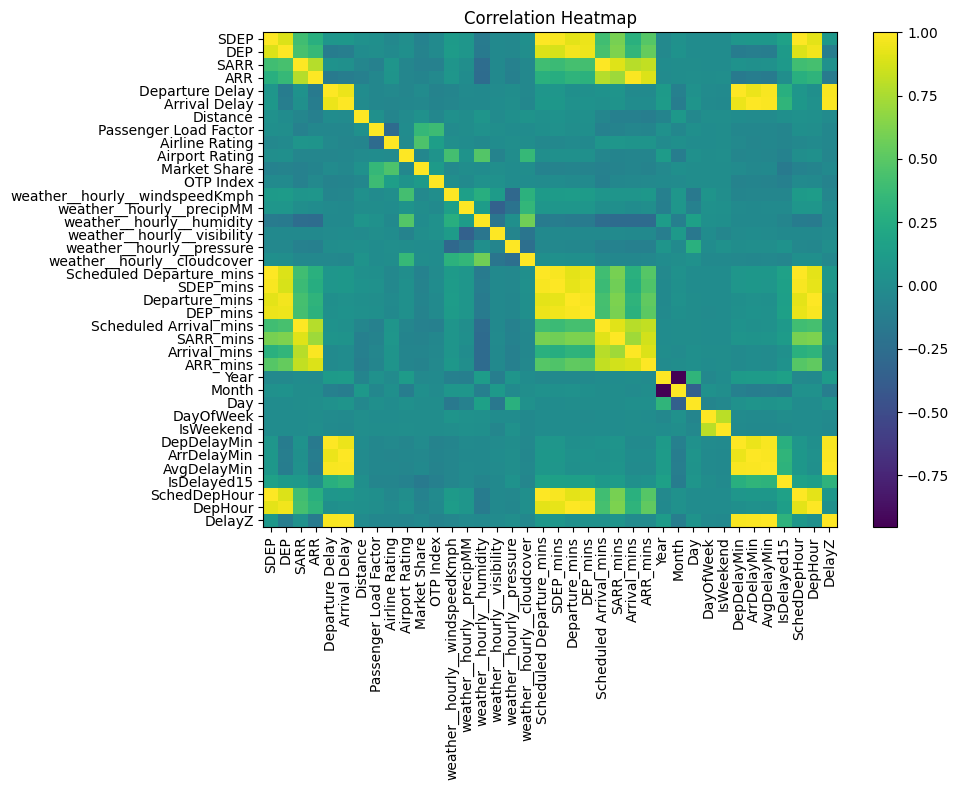

In [37]:
# =============================
# Correlation Analysis & Heatmap
# =============================
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
corr = df[num_cols].corr()

print("Numeric columns considered for correlation:", len(num_cols))
display(corr.round(3))

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.title("Correlation Heatmap")
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.tight_layout()
plt.show()


Top 10 Airlines by Avg Delay (min):


Airline
Air India    53.805179
SpiceJet     41.174479
Go Air       30.069277
Spicejet     22.617910
Air Asia     22.216945
Indigo       21.152480
Vistara      16.297262
Name: AvgDelayMin, dtype: float64

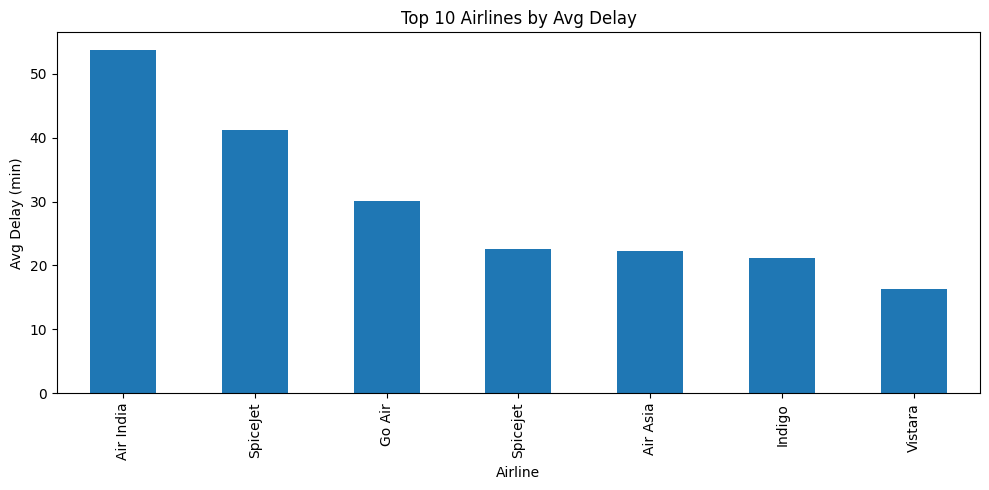

Top 10 Routes by Avg Delay (min):


Route
BOM → DEL    50.047619
CCU → DEL    38.460443
DEL → HYD    30.854917
BLR → DEL    17.037383
BLR → BOM    14.963987
Name: AvgDelayMin, dtype: float64

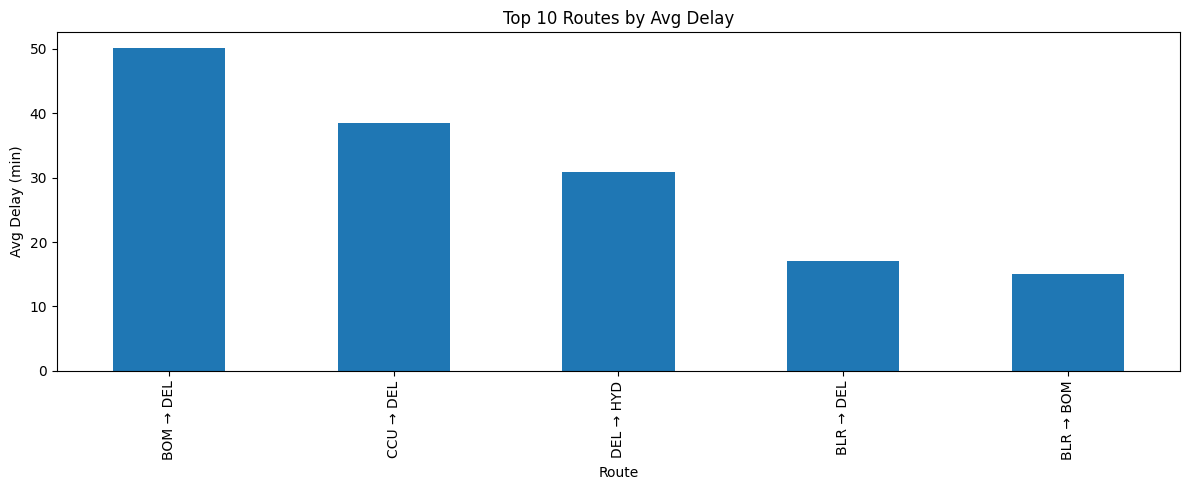

Top 10 Origin Airports by Avg Delay (min):


From
BOM    50.047619
CCU    38.460443
DEL    30.854917
BLR    16.072843
Name: AvgDelayMin, dtype: float64

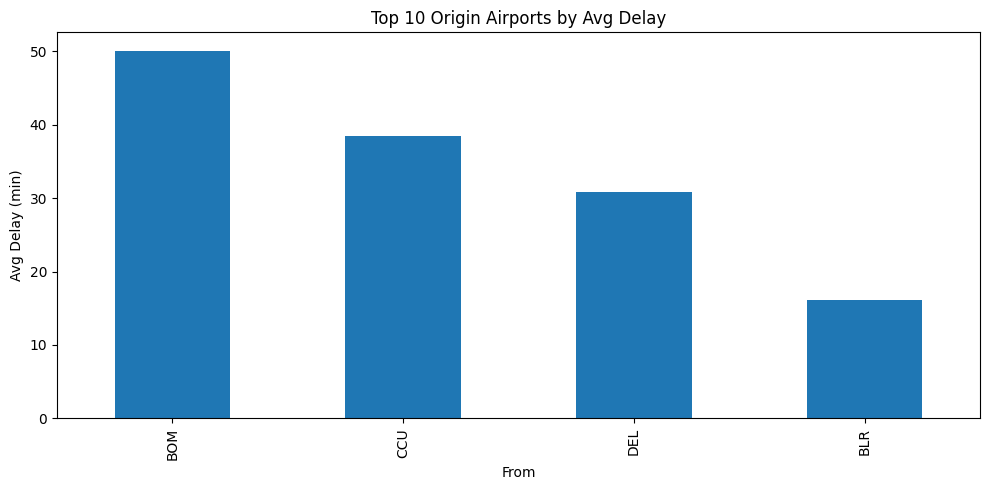

Top 10 Destination Airports by Avg Delay (min):


To
HYD    30.854917
DEL    30.376443
BOM    14.963987
Name: AvgDelayMin, dtype: float64

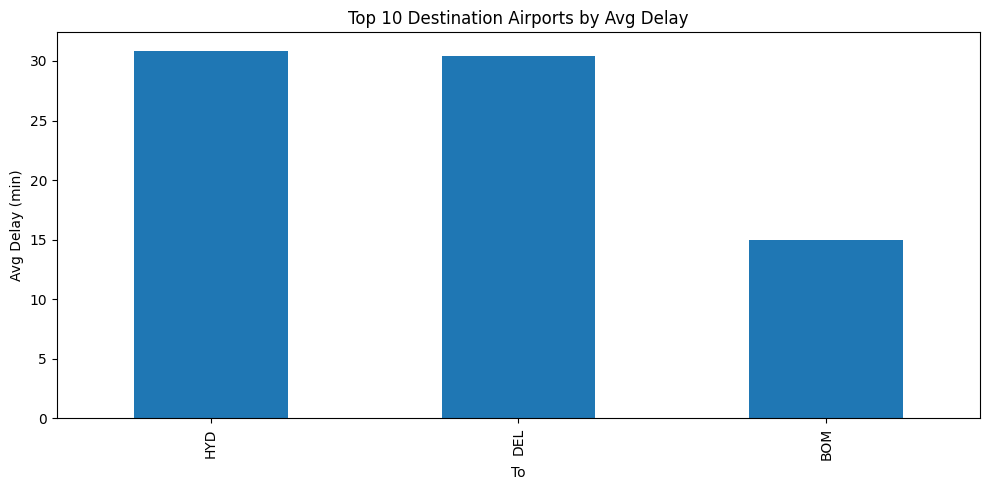

In [38]:
# =============================
# Top-10 Insights
# =============================
# Top delayed airlines
if "Airline" in df.columns and "AvgDelayMin" in df.columns:
    top_airlines = df.groupby("Airline")["AvgDelayMin"].mean().sort_values(ascending=False).head(10)
    print("Top 10 Airlines by Avg Delay (min):")
    display(top_airlines)

    plt.figure(figsize=(10,5))
    top_airlines.plot(kind="bar")
    plt.ylabel("Avg Delay (min)")
    plt.title("Top 10 Airlines by Avg Delay")
    plt.tight_layout()
    plt.show()

# Top delayed routes
if "Route" in df.columns and "AvgDelayMin" in df.columns:
    top_routes = df.groupby("Route")["AvgDelayMin"].mean().sort_values(ascending=False).head(10)
    print("Top 10 Routes by Avg Delay (min):")
    display(top_routes)

    plt.figure(figsize=(12,5))
    top_routes.plot(kind="bar")
    plt.ylabel("Avg Delay (min)")
    plt.title("Top 10 Routes by Avg Delay")
    plt.tight_layout()
    plt.show()

# Top origin airports by delay
if "From" in df.columns and "AvgDelayMin" in df.columns:
    top_from = df.groupby("From")["AvgDelayMin"].mean().sort_values(ascending=False).head(10)
    print("Top 10 Origin Airports by Avg Delay (min):")
    display(top_from)

    plt.figure(figsize=(10,5))
    top_from.plot(kind="bar")
    plt.ylabel("Avg Delay (min)")
    plt.title("Top 10 Origin Airports by Avg Delay")
    plt.tight_layout()
    plt.show()

# Top destination airports by delay
if "To" in df.columns and "AvgDelayMin" in df.columns:
    top_to = df.groupby("To")["AvgDelayMin"].mean().sort_values(ascending=False).head(10)
    print("Top 10 Destination Airports by Avg Delay (min):")
    display(top_to)

    plt.figure(figsize=(10,5))
    top_to.plot(kind="bar")
    plt.ylabel("Avg Delay (min)")
    plt.title("Top 10 Destination Airports by Avg Delay")
    plt.tight_layout()
    plt.show()


Monthly average delay:


,Year,Month,AvgDelayMin,YearMonth
0,2019,1,27.37500,2019-01
1,2019,2,25.06250,2019-02
2,2019,3,48.01145,2019-03
3,2019,4,22.30000,2019-04
4,2019,5,9.50000,2019-05


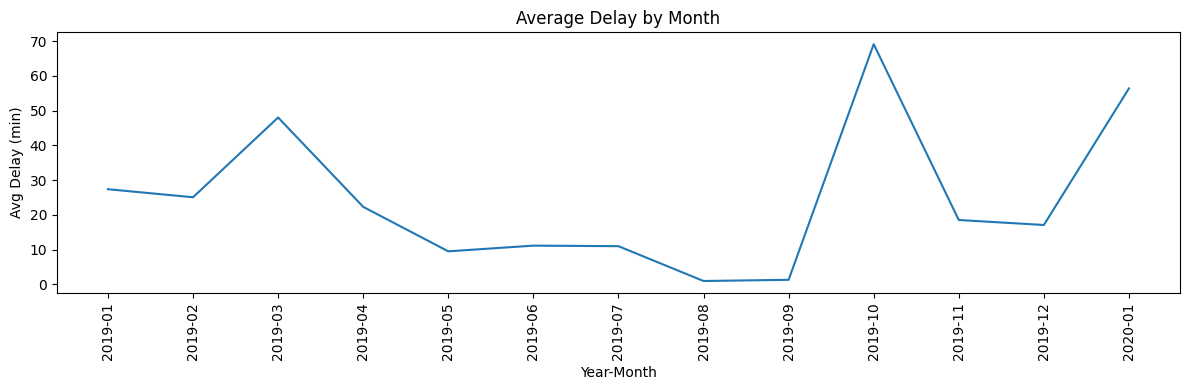

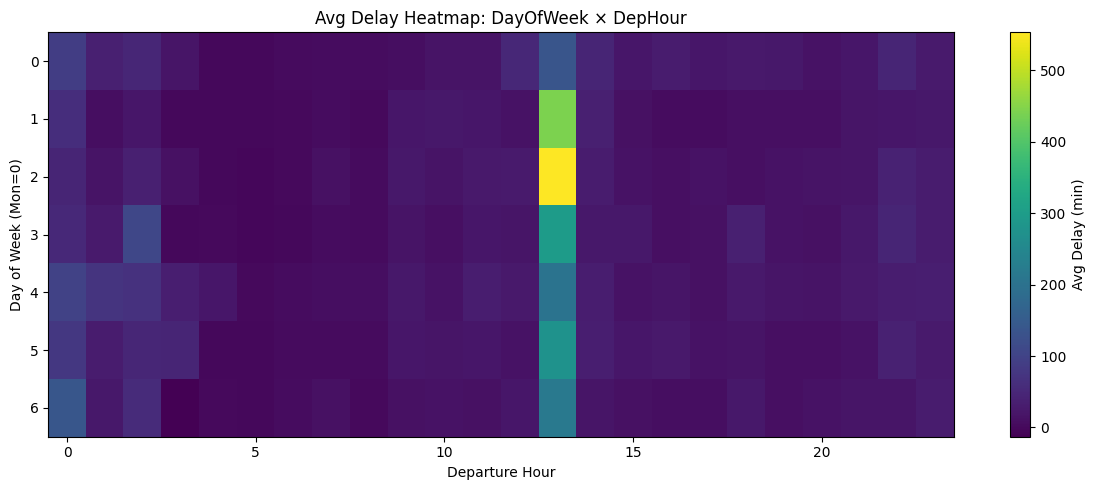

In [39]:
# =============================
# Time-based Trends
# =============================
# Monthly averages
if {"Year","Month","AvgDelayMin"}.issubset(df.columns):
    monthly = df.groupby(["Year","Month"])["AvgDelayMin"].mean().reset_index()
    monthly["YearMonth"] = monthly["Year"].astype(str) + "-" + monthly["Month"].astype(str).str.zfill(2)
    print("Monthly average delay:")
    display(monthly.head())

    plt.figure(figsize=(12,4))
    plt.plot(monthly["YearMonth"], monthly["AvgDelayMin"])
    plt.title("Average Delay by Month")
    plt.xlabel("Year-Month")
    plt.ylabel("Avg Delay (min)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Day-of-week × DepHour heatmap
if {"DayOfWeek","DepHour","AvgDelayMin"}.issubset(df.columns):
    heat = df.pivot_table(index="DayOfWeek", columns="DepHour", values="AvgDelayMin", aggfunc="mean")
    plt.figure(figsize=(12,5))
    plt.imshow(heat, aspect='auto', interpolation='nearest')
    plt.title("Avg Delay Heatmap: DayOfWeek × DepHour")
    plt.xlabel("Departure Hour")
    plt.ylabel("Day of Week (Mon=0)")
    plt.colorbar(label="Avg Delay (min)")
    plt.tight_layout()
    plt.show()


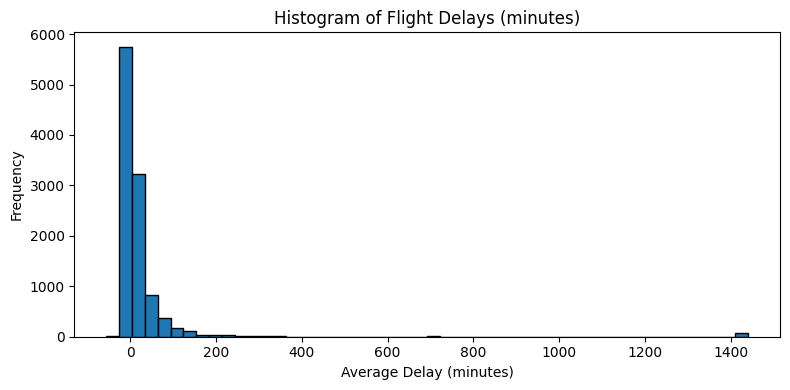

C:\Users\HP\AppData\Local\Temp\ipykernel_21360\3579244482.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_airline, labels=airline_order, showfliers=False)


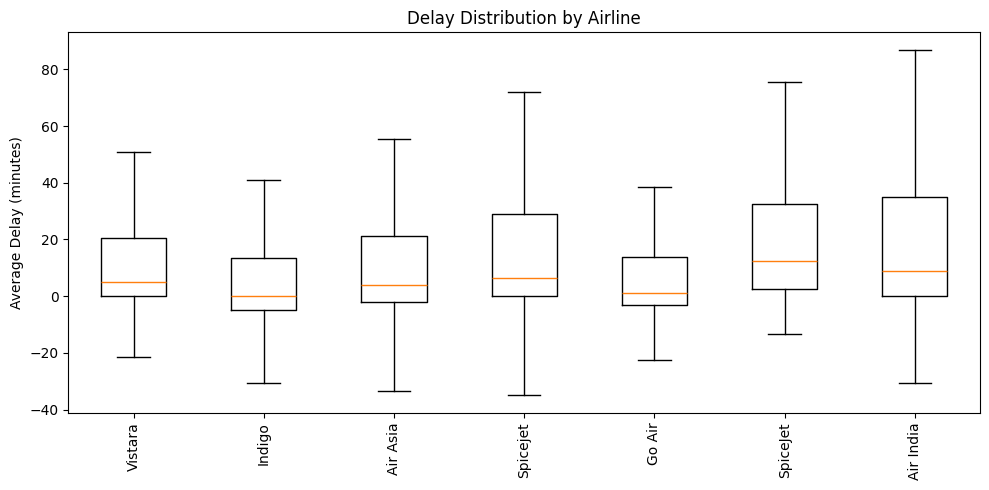

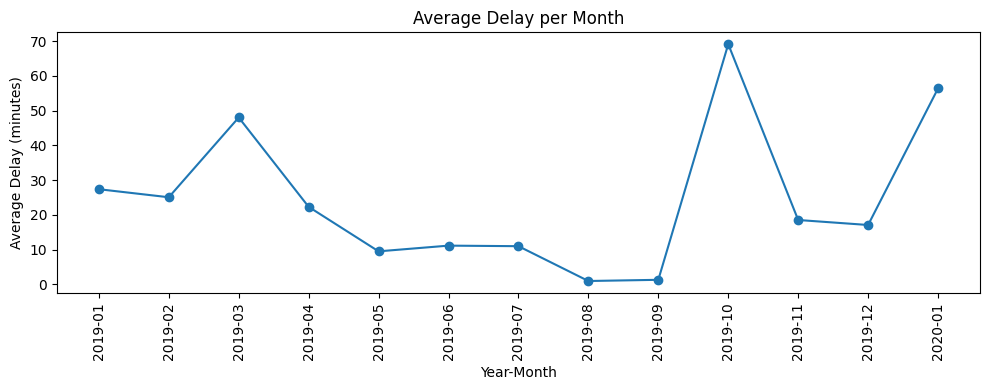

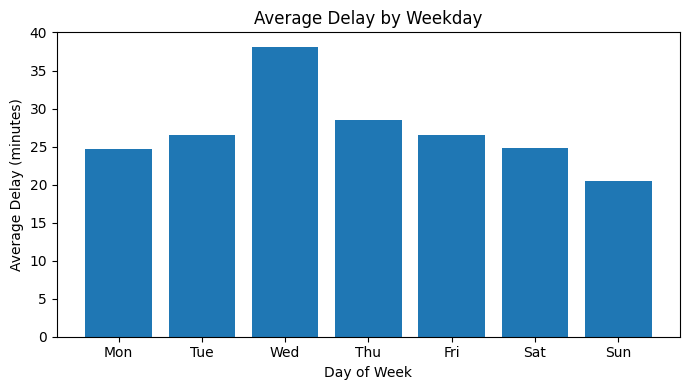

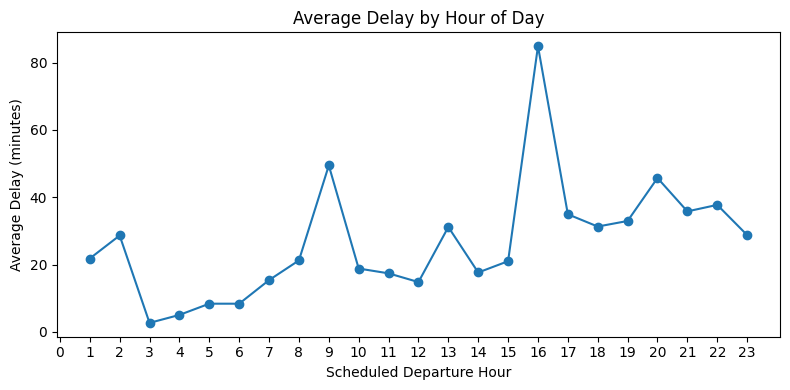

In [40]:
# === Flight Delay Analysis: 3.1 & 3.2 ===
# Requirements: pandas, numpy, matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load data
# -----------------------------
CSV_PATH = "flight_delay.csv"   # change if needed
df = pd.read_csv(CSV_PATH)

# -----------------------------
# Basic parsing & features
# -----------------------------

# Convert delays to numeric and make a single delay metric
df["Departure Delay"] = pd.to_numeric(df.get("Departure Delay"), errors="coerce")
df["Arrival Delay"]   = pd.to_numeric(df.get("Arrival Delay"), errors="coerce")
df["AvgDelayMin"]     = df[["Departure Delay", "Arrival Delay"]].mean(axis=1)

# Parse date
df["Used Date"] = pd.to_datetime(df["Used Date"], errors="coerce", dayfirst=True)
df = df.dropna(subset=["Used Date"])

# Extract calendar features
df["Year"]      = df["Used Date"].dt.year
df["Month"]     = df["Used Date"].dt.month
df["DayOfWeek"] = df["Used Date"].dt.dayofweek  # Monday=0

# Helper to get hour from time columns like "HHMM" or "HH:MM"
def to_hour(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # If already numeric HHMM (e.g., 930 or 1745)
    if s.isdigit() and (3 <= len(s) <= 4):
        if len(s) == 3:
            h = int(s[0])
        else:
            h = int(s[:2])
        return h if 0 <= h <= 23 else np.nan
    # If "HH:MM"
    if ":" in s:
        try:
            h = int(s.split(":")[0])
            return h if 0 <= h <= 23 else np.nan
        except:
            return np.nan
    return np.nan

# Choose the best available scheduled departure time column
hour_col = None
if "SDEP" in df.columns:
    hour_col = "SDEP"
elif "Scheduled Departure" in df.columns:
    hour_col = "Scheduled Departure"

df["Hour"] = df[hour_col].apply(to_hour) if hour_col else np.nan

# --------------------------------
# 3.1 Delay Distribution
# --------------------------------

# Histogram of delay minutes
plt.figure(figsize=(8, 4))
plt.hist(df["AvgDelayMin"].dropna(), bins=50, edgecolor="black")
plt.title("Histogram of Flight Delays (minutes)")
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Boxplot of delay by airline (if Airline is present)
if "Airline" in df.columns:
    # Order airlines by mean delay (ascending) for a cleaner plot
    airline_order = (
        df.groupby("Airline")["AvgDelayMin"]
          .mean()
          .sort_values()
          .index
          .tolist()
    )

    # Build the list of series per airline
    data_by_airline = [df.loc[df["Airline"] == a, "AvgDelayMin"].dropna() for a in airline_order]

    plt.figure(figsize=(10, 5))
    plt.boxplot(data_by_airline, labels=airline_order, showfliers=False)
    plt.xticks(rotation=90)
    plt.ylabel("Average Delay (minutes)")
    plt.title("Delay Distribution by Airline")
    plt.tight_layout()
    plt.show()

# --------------------------------
# 3.2 Delay Trends
# --------------------------------

# Average delay per month (line over time)
monthly = (
    df.groupby(["Year", "Month"], as_index=False)["AvgDelayMin"]
      .mean()
      .sort_values(["Year", "Month"])
)
monthly["YearMonth"] = monthly["Year"].astype(str) + "-" + monthly["Month"].astype(str).str.zfill(2)

plt.figure(figsize=(10, 4))
plt.plot(monthly["YearMonth"], monthly["AvgDelayMin"], marker="o")
plt.title("Average Delay per Month")
plt.xlabel("Year-Month")
plt.ylabel("Average Delay (minutes)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Average delay by weekday (bar)
weekday_mean = df.groupby("DayOfWeek")["AvgDelayMin"].mean()
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.figure(figsize=(7, 4))
plt.bar(weekday_mean.index, weekday_mean.values, tick_label=weekday_labels)
plt.title("Average Delay by Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Average Delay (minutes)")
plt.tight_layout()
plt.show()

# Average delay by hour (line)
if df["Hour"].notna().any():
    hourly_mean = df.groupby("Hour")["AvgDelayMin"].mean().dropna()
    plt.figure(figsize=(8, 4))
    plt.plot(hourly_mean.index, hourly_mean.values, marker="o")
    plt.title("Average Delay by Hour of Day")
    plt.xlabel("Scheduled Departure Hour")
    plt.ylabel("Average Delay (minutes)")
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()
else:
    print("No usable scheduled departure time column found for hourly trend.")


AvgDelayMin                       1.000000
weather__hourly__pressure         0.009769
weather__hourly__visibility      -0.006982
weather__hourly__precipMM        -0.020341
weather__hourly__humidity        -0.025232
weather__hourly__cloudcover      -0.043582
weather__hourly__windspeedKmph   -0.057405
Name: AvgDelayMin, dtype: float64


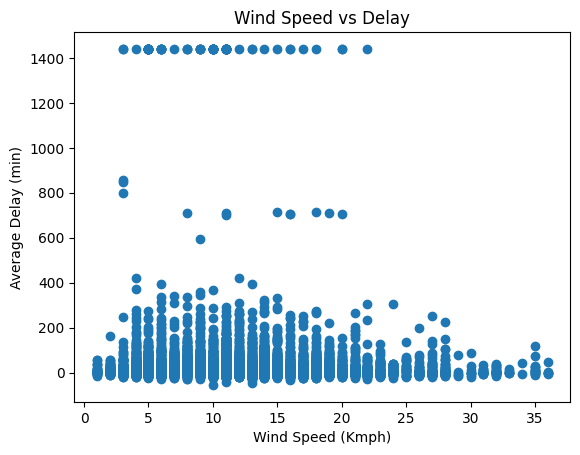

In [41]:
weather_cols = [
    "weather__hourly__windspeedKmph", "weather__hourly__precipMM",
    "weather__hourly__humidity", "weather__hourly__visibility",
    "weather__hourly__pressure", "weather__hourly__cloudcover"
]

corr_weather = df[weather_cols + ["AvgDelayMin"]].corr()["AvgDelayMin"].sort_values(ascending=False)
print(corr_weather)

# Scatter plots for top correlated weather factors
plt.scatter(df["weather__hourly__windspeedKmph"], df["AvgDelayMin"])
plt.xlabel("Wind Speed (Kmph)")
plt.ylabel("Average Delay (min)")
plt.title("Wind Speed vs Delay")
plt.show()


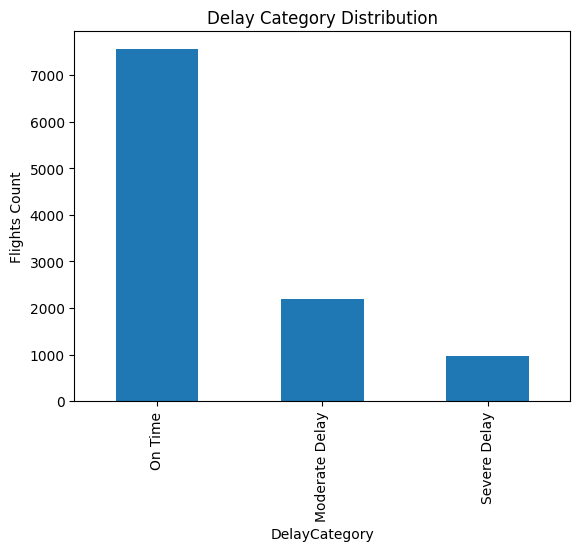

In [42]:
def classify_delay(x):
    if x <= 15: return "On Time"
    elif x <= 60: return "Moderate Delay"
    else: return "Severe Delay"

df["DelayCategory"] = df["AvgDelayMin"].apply(classify_delay)

df["DelayCategory"].value_counts().plot(kind="bar")
plt.title("Delay Category Distribution")
plt.ylabel("Flights Count")
plt.show()


In [43]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load your cleaned dataset
df = pd.read_csv("flight_delay.csv")

# Convert delays to categorical bins
def delay_category(x):
    if x <= 15: return "On-Time"
    elif x <= 60: return "Moderate Delay"
    else: return "Severe Delay"

df["Departure Delay"] = pd.to_numeric(df["Departure Delay"], errors="coerce")
df["Arrival Delay"]   = pd.to_numeric(df["Arrival Delay"], errors="coerce")
df["AvgDelayMin"]     = df[["Departure Delay", "Arrival Delay"]].mean(axis=1)
df["DelayCategory"]   = df["AvgDelayMin"].apply(delay_category)

# Discretize weather features
df["WindCategory"] = pd.cut(df["weather__hourly__windspeedKmph"], bins=[0,10,20,40,100],
                            labels=["Calm","Breezy","Windy","Stormy"])
df["HumidityCategory"] = pd.cut(df["weather__hourly__humidity"], bins=[0,50,70,85,100],
                                labels=["Low","Moderate","High","Very High"])
df["VisibilityCategory"] = pd.cut(df["weather__hourly__visibility"], bins=[0,2,5,10,100],
                                  labels=["Low","Moderate","Good","Excellent"])
df["CloudCategory"] = pd.cut(df["weather__hourly__cloudcover"], bins=[0,25,50,75,100],
                             labels=["Clear","Partly Cloudy","Cloudy","Overcast"])

# Select relevant columns for rule mining
cols = ["WindCategory","HumidityCategory","VisibilityCategory","CloudCategory","DelayCategory"]
df_rules = df[cols].dropna()

# One-hot encode
df_onehot = pd.get_dummies(df_rules)

# Mine frequent itemsets
frequent_items = apriori(df_onehot, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_items, metric="lift", min_threshold=1.0)

# Focus on rules that predict delays
delay_rules = rules[rules["consequents"].astype(str).str.contains("DelayCategory")]

# Sort by confidence
delay_rules = delay_rules.sort_values("confidence", ascending=False).head(10)
print(delay_rules[["antecedents","consequents","support","confidence","lift"]])


                                           antecedents  \
190  (WindCategory_Breezy, CloudCategory_Partly Clo...   
440  (VisibilityCategory_Good, WindCategory_Breezy,...   
198      (VisibilityCategory_Good, WindCategory_Windy)   
447  (WindCategory_Breezy, CloudCategory_Partly Clo...   
239      (CloudCategory_Cloudy, HumidityCategory_High)   
485  (CloudCategory_Cloudy, VisibilityCategory_Good...   
22                                (WindCategory_Windy)   
269  (VisibilityCategory_Good, CloudCategory_Partly...   
61                       (CloudCategory_Partly Cloudy)   
480  (VisibilityCategory_Good, HumidityCategory_Hig...   

                                          consequents   support  confidence  \
190                           (DelayCategory_On-Time)  0.092111    0.776959   
440                           (DelayCategory_On-Time)  0.091128    0.776536   
198                           (DelayCategory_On-Time)  0.052557    0.774557   
447  (VisibilityCategory_Good, DelayCategory_

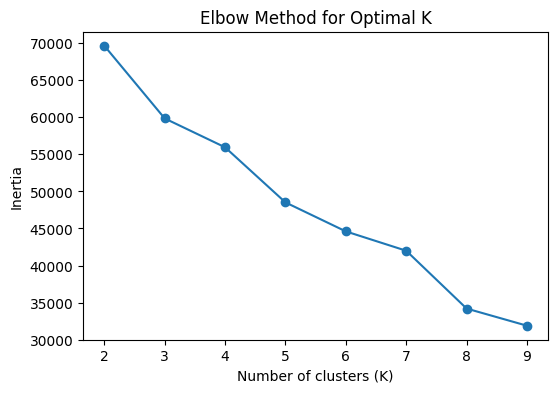

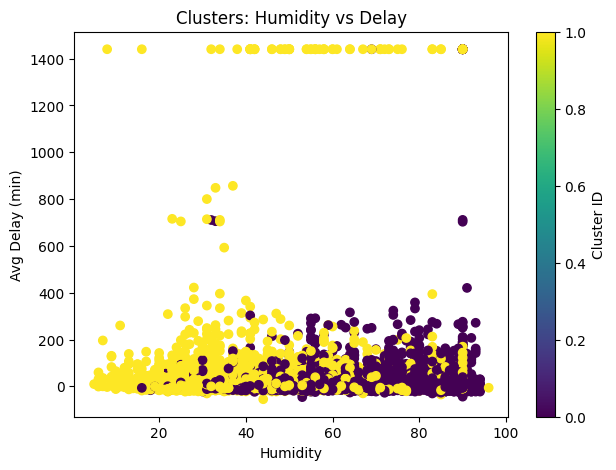

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select numeric features for clustering
features = [
    "AvgDelayMin","Distance","Passenger Load Factor","Airline Rating","Airport Rating",
    "weather__hourly__windspeedKmph","weather__hourly__humidity","weather__hourly__visibility"
]

df_cluster = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Determine optimal k using Elbow Method
inertias = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.show()

# Suppose K=3 looks good from the elbow
kmeans = KMeans(n_clusters=2, random_state=42)
df_cluster["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualize 2D projection (example: weather vs delay)
plt.figure(figsize=(7,5))
plt.scatter(df_cluster["weather__hourly__humidity"], df_cluster["AvgDelayMin"],
            c=df_cluster["Cluster"], cmap="viridis")
plt.title("Clusters: Humidity vs Delay")
plt.xlabel("Humidity")
plt.ylabel("Avg Delay (min)")
plt.colorbar(label="Cluster ID")
plt.show()


In [45]:
delay_summary = df.groupby("Airline")["AvgDelayMin"].agg(["mean","median","std","count"])
airport_summary = df.groupby("From")["AvgDelayMin"].mean().sort_values(ascending=False)
print("Delay Summary by Airline:")
display(delay_summary)
display(airport_summary)

Delay Summary by Airline:


,mean,median,std,count
Airline,,,,
Air Asia,22.216945,4.00,95.309583,1316
Air India,53.805179,9.00,199.095374,1622
Go Air,30.069277,1.00,133.906546,996
Indigo,21.152480,0.00,130.812347,4053
SpiceJet,41.174479,12.25,152.525775,192
Spicejet,22.617910,6.50,46.930246,1005
Vistara,16.297262,5.00,49.046532,1534


From
BOM    50.047619
CCU    38.460443
DEL    30.854917
BLR    16.072843
Name: AvgDelayMin, dtype: float64

In [46]:
df["WeatherType"] = df["weather__hourly__weatherDesc__value"].str.lower()

rainy = df[df["WeatherType"].str.contains("rain", na=False)]
foggy = df[df["WeatherType"].str.contains("fog", na=False)]
clear = df[df["WeatherType"].str.contains("clear", na=False)]

print("Rainy Avg Delay:", rainy["AvgDelayMin"].mean())
print("Foggy Avg Delay:", foggy["AvgDelayMin"].mean())
print("Clear Avg Delay:", clear["AvgDelayMin"].mean())


Rainy Avg Delay: 17.214203565267397
Foggy Avg Delay: nan
Clear Avg Delay: 39.57245724572457


C:\Users\HP\AppData\Local\Temp\ipykernel_21360\2189677868.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heat = df.pivot_table(


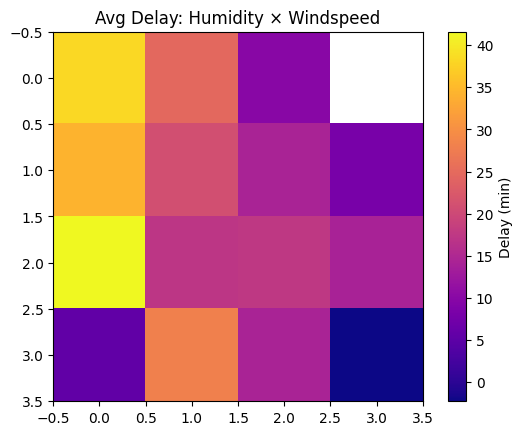

In [47]:
heat = df.pivot_table(
    values="AvgDelayMin",
    index=pd.cut(df["weather__hourly__humidity"], bins=[0,50,70,85,100], labels=["Low","Moderate","High","Very High"]),
    columns=pd.cut(df["weather__hourly__windspeedKmph"], bins=[0,10,20,30,100], labels=["Calm","Breezy","Windy","Stormy"]),
    aggfunc="mean"
)
plt.imshow(heat, cmap="plasma", interpolation="nearest")
plt.title("Avg Delay: Humidity × Windspeed")
plt.colorbar(label="Delay (min)")
plt.show()


In [48]:
df["Month"] = pd.to_datetime(df["Used Date"]).dt.month
airport_month = df.groupby(["From","Month"])["AvgDelayMin"].mean().reset_index()
print("Airport Monthly Delay Averages:")
display(airport_month)


Airport Monthly Delay Averages:


C:\Users\HP\AppData\Local\Temp\ipykernel_21360\1643616787.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Month"] = pd.to_datetime(df["Used Date"]).dt.month


,From,Month,AvgDelayMin
0,BLR,1,38.714713
1,BLR,2,3.000000
2,BLR,3,111.209302
3,BLR,5,-2.821429
4,BLR,6,-13.750000
5,BLR,7,4.318182
6,BLR,8,0.222222
7,BLR,9,-3.820000
8,BLR,10,26.713636
9,BLR,11,8.679409


In [49]:
from mlxtend.frequent_patterns import apriori, association_rules

df["WeatherBin"] = pd.cut(df["weather__hourly__precipMM"], bins=[0,1,5,20,100], labels=["Dry","Drizzle","Rain","Heavy Rain"])
df["DelayCat"] = pd.cut(df["AvgDelayMin"], bins=[0,15,60,300], labels=["OnTime","Moderate","Severe"])

rule_df = df[["From","WeatherBin","DelayCat"]].dropna()
onehot = pd.get_dummies(rule_df)
frequent = apriori(onehot, min_support=0.05, use_colnames=True)
rules = association_rules(frequent, metric="confidence", min_threshold=0.6)

delay_rules = rules[rules["consequents"].astype(str).str.contains("DelayCat")]
print(delay_rules.sort_values("confidence", ascending=False).head(10))



Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []
